<a href="https://colab.research.google.com/github/marektopolewski/how-old-is-your-brain/blob/main/brain_age_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age regression from brain MRI

In [1]:
! pip install SimpleITK==1.2.4 tqdm

     |████████████████████████████████| 42.5MB 73kB/s 


### Downloading the data

In [3]:
# Data source: Imperial College London, Machine Learning for Imaging Course,
# Dr. Ben Glocker and Prof. Daniel Rueckert
# https://www.imperial.ac.uk/computing/current-students/courses/70014/

! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip -q brainage-data.zip
! rm brainage-data.zip

! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip -q brainage-testdata.zip
! rm brainage-testdata.zip

--2021-03-16 15:22:02--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  37.4MB/s    in 13s     

2021-03-16 15:22:16 (34.9 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

--2021-03-16 15:22:20--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-03-16 15:22:22 (228 M

In [4]:
# data directory
data_dir = 'data/brain_age/'

## Age prediction using regression CNNs


#### Imports

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import SimpleITK as sitk

%matplotlib inline
import matplotlib.pyplot as plt

#### GPU settings

In [6]:
cuda_dev = '0'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))

Device: cuda:0
GPU: Tesla T4


#### Helper methods

In [7]:
# Source: Imperial College London, Machine Learning for Imaging Course,
# Dr. Ben Glocker and Prof. Daniel Rueckert
# https://www.imperial.ac.uk/computing/current-students/courses/70014/

def zero_mean_unit_var(image, mask):
    """Copied from Task A."""
    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)
    msk_array = sitk.GetArrayFromImage(mask)
    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])
    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0
    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)
    return image_normalised
  
def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)

#### Dataset

In [8]:
class ImageAgeRegressionDataset(Dataset):
    """Dataset for image age regression."""

    def __init__(self, file_list_img, file_list_msk, gender_list, age_labels, img_spacing, img_size):
        self.samples = np.array([])
        self.img_names = np.array([])
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)
            gender = gender_list[idx]
            age = age_labels[idx]

            # pre-processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'msk': msk, 'gender': gender, 'age': age}

            self.samples = np.append(self.samples, sample)
            self.img_names = np.append(self.img_names, os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        img = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)
        gender = torch.FloatTensor([sample['gender']])
        age = torch.FloatTensor([sample['age']])

        return {'img': img, 'msk': msk, 'gender': gender, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

#### Hyper-params

In [9]:
rnd_seed = 42 # fixed random seed

img_size = [96, 96, 96]
img_spacing = [1, 1, 1]

num_epochs = 30
learning_rate = 0.001
batch_size = 2
loss_fn = nn.L1Loss(reduction='sum')

val_interval = 5

out_dir = './output_b'
data_dir = 'data/brain_age/'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Model

In [10]:
class BlehBlock(nn.Module):
  """
  A custom network (bLEhNET) block.
  """
  def __init__(self, num_blocks):
    super(BlehBlock, self).__init__()
    blocks = []
    for i in range(1, num_blocks + 1):
        blocks += [ nn.Conv3d(2**(i+2), 2**(i+3), kernel_size=3, stride=1, padding=1),
                    nn.ReLU(True),
                    nn.BatchNorm3d(2**(i+3)),
                    nn.MaxPool3d(2) ]
    self.main = nn.Sequential(*blocks)
  
  def forward(self, x):
    return self.main(x)

class VGGBlock(nn.Module):
  """
  A single VGG network block.
  """
  def __init__(self, in_fm, out_fm, num_convs=1):
    super(VGGBlock, self).__init__()
    convs = []
    curr_fm = in_fm
    for i in range(num_convs - 1):
      convs += [ nn.Conv3d(curr_fm, out_fm, kernel_size=3, stride=1, padding=1),
                 nn.ReLU(True) ]
      curr_fm = out_fm
    self.main = nn.Sequential(
        *convs,
        nn.Conv3d(curr_fm, out_fm, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(out_fm),
        nn.ReLU(True),
        nn.MaxPool3d(2)
    )
  
  def forward(self, x):
    return self.main(x)

class ResidualBlock(nn.Module):
  """
  A signle ResNet block with a given number of input (in_fm) and output (out_fm) feature maps.
  If the bloack perfroms downsampling then modify the skip connection using convolutions to match
  the output channel dimensions.

  References:
  [1] B. Kainz, "Imperial College London: Deep Learning Courswork 1",
      https://colab.research.google.com/drive/151W_XEOCcwtO761NJibJKuhoGp1jb9C6?usp=sharing
  [2] PyTorch, "Datasets, Transforms and Models specific to Computer Vision",
      https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
  """
  def __init__(self, in_fm, out_fm, stride=1):
    super(ResidualBlock, self).__init__()
    self.main = nn.Sequential(
        nn.Conv3d(in_fm, out_fm, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm3d(out_fm),
        nn.ReLU(True),
        nn.Conv3d(out_fm, out_fm, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm3d(out_fm)
    )
    self.shortcut = nn.Sequential()

    if stride != 1 or in_fm != out_fm:
      self.shortcut = nn.Sequential(
          nn.Conv3d(in_fm, out_fm, kernel_size=1, stride=stride, padding=0, bias=False),
          nn.BatchNorm3d(out_fm)
      )

  def forward(self, x): 
    out = self.main(x) + self.shortcut(x)
    out = F.relu(out) 
    return out

class ResidualBottleneck(nn.Module):
  """
  A signle ResNet bottleneck block, similar to ResidualBlock but this class utilises 1x1
  convolutions and is applicable to larger ResNets (50, 101, 152).

  References:
  [1] PyTorch, "Datasets, Transforms and Models specific to Computer Vision",
      https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
  """
  def __init__(self, in_fm, out_fm, stride=1):
    super(ResidualBottleneck, self).__init__()
    exp = 4
    self.main = nn.Sequential(
        nn.Conv3d(in_fm, out_fm, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm3d(out_fm),
        nn.ReLU(True),
        nn.Conv3d(out_fm, out_fm, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm3d(out_fm),
        nn.ReLU(True),
        nn.Conv3d(out_fm, out_fm * exp, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm3d(out_fm * exp)
    )
    self.shortcut = nn.Sequential()

    if stride != 1 or in_fm != out_fm * exp:
      self.shortcut = nn.Sequential(
          nn.Conv3d(in_fm, out_fm * exp, kernel_size=1, stride=stride, padding=0, bias=False),
          nn.BatchNorm3d(out_fm * exp)
      )
    
  def forward(self, x):
    out = self.main(x)
    out += self.shortcut(x)
    out = F.relu(out) 
    return out


def make_blocks(cls, in_fm, out_fm, num_blocks, stride, exp):
  """Factory method for making multiple residual blocks"""
  strides = [stride] + [1] * (num_blocks - 1)
  blocks = nn.Sequential()
  curr_fm = in_fm
  for i, stride in enumerate(strides):
    blocks.add_module(f"block{i}_{in_fm}-{out_fm}", cls(curr_fm, out_fm, stride))
    curr_fm = out_fm * exp
  return blocks

In [11]:
class AgeRegressorNet(nn.Module):

  def __init__(self, arch='none', h_dim=256, base_dim=64):
    super(AgeRegressorNet, self).__init__()

    self.arch = arch
    self.h_dim = h_dim
    self.base_dim = base_dim

    if 'blehnet' in arch:
      num_blocks = 5
      flat_size = (np.array(img_size) // 2**num_blocks).prod()
      self.net = nn.Sequential(
          nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1),
          BlehBlock(num_blocks),
          nn.Flatten(),
          nn.Linear(2**(num_blocks+3) * flat_size, self.h_dim),
          nn.ReLU(True)
      )
      self.fc = nn.Linear(self.h_dim + 1, 1)

    elif 'vgg' in arch:
      vgg_configs = {
          "11": [1, 1, 2, 2, 2],
          "13": [2, 2, 2, 2, 2],
          "16": [2, 2, 3, 3, 3],
      }
      vgg_arch = arch.split('-')[1]
      if vgg_arch not in vgg_configs.keys():
        raise Exception(f'Architecture {arch} not defined.')
      dim = self.base_dim
      num_convs = vgg_configs[vgg_arch]
      self.net = nn.Sequential(
        VGGBlock(      1, dim *  1, num_convs[0]),
        VGGBlock(dim * 1, dim *  2, num_convs[1]),
        VGGBlock(dim * 2, dim *  4, num_convs[2]),
        VGGBlock(dim * 4, dim *  8, num_convs[3]),
        VGGBlock(dim * 8, dim * 16, num_convs[4]),
        nn.AdaptiveMaxPool3d((1, 1, 1)),
        nn.Flatten(),
        nn.Linear(dim * 16, 1),
      )
      # self.out_dim = dim * 16

    elif 'resnet' in arch:
      resnet_configs = {
          "152": ([3, 8, 36, 3], ResidualBottleneck, 4),
          "101": ([3, 4, 23, 3], ResidualBottleneck, 4),
          "50":  ([3, 4, 6, 3],  ResidualBottleneck, 4),
          "34":  ([3, 4, 6, 3],  ResidualBlock,      1),
          "0":   ([2, 2, 2, 2],  ResidualBlock,      1)
      }
      resnet_arch = arch.split('-')[1]
      if resnet_arch not in resnet_configs.keys():
        raise Exception(f'Architecture {arch} not defined.')
      dim = self.base_dim
      num_blocks, block, exp = resnet_configs[resnet_arch]
      self.net = nn.Sequential(
          make_blocks(block,             1, dim * 1, num_blocks[0], 1, exp),
          make_blocks(block, dim * 1 * exp, dim * 2, num_blocks[1], 2, exp),
          make_blocks(block, dim * 2 * exp, dim * 4, num_blocks[2], 2, exp),
          make_blocks(block, dim * 4 * exp, dim * 8, num_blocks[3], 2, exp),
          nn.AdaptiveMaxPool3d((1, 1, 1)),
          nn.Flatten(),
          nn.Linear(dim * 8 * exp, 1),
      )
      # self.out_dim = dim * 8 * exp
    
    else:
      raise Exception(f'Architecture {arch} not defined.')
  
  def forward(self, x, z=None):
    out = self.net(x)
    if self.arch == 'blehnet':
      out = torch.cat([out, z], -1)
      out = self.fc(out)
    return out.squeeze(-1)
  
  def count_params(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### Training and evaluation functions

In [12]:
def train(model, optimizer, train_loader):
    loss_train = 0
    for batch_samples in train_loader:
        img, gender = batch_samples['img'].to(device), batch_samples['gender'].to(device)
        age = batch_samples['age'].to(device)
        optimizer.zero_grad()
        prd = model(img, gender)
        loss = loss_fn(prd, age.squeeze(1))
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    return loss_train / len(train_loader)

def validate(model, valid_loader):
  loss_val = 0
  with torch.no_grad():
      for batch_samples in valid_loader:
          img, gender = batch_samples['img'].to(device), batch_samples['gender'].to(device)
          age = batch_samples['age'].to(device)
          prd = model(img, gender)
          loss_val += loss_fn(prd, age.squeeze(1)).item()
      return loss_val / len(valid_loader)

def evaluate(model, valid_loader):
  y_actual = y_predicted = torch.LongTensor([])
  with torch.no_grad():
      for batch_samples in valid_loader:
          img, gender = batch_samples['img'].to(device), batch_samples['gender'].to(device)
          age = batch_samples['age'].to(device)
          y_actual = torch.cat([y_actual, age.cpu()])
          prd = model(img, gender)
          y_predicted = torch.cat([y_predicted, prd.cpu()], dim=-1)
      y_actual = y_actual.numpy()
      y_predicted = y_predicted.numpy()
      mae = mean_absolute_error(y_actual, y_predicted)
      r2score = r2_score(y_actual, y_predicted)
      return mae, r2score, y_actual, y_predicted

#### Data preprocessing

In [13]:
def make_loader(path, batch_size, shuffle):
  meta_data = pd.read_csv(data_dir + path)
  ids = list(meta_data['subject_id'])
  files_img = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz'   for f in ids]
  files_msk = [data_dir + 'masks/sub-'  + f + '_T1w_brain_mask.nii.gz' for f in ids]
  genders = meta_data['gender_code']
  age_labels = meta_data['age']
  dataset = ImageAgeRegressionDataset(files_img, files_msk, genders, age_labels, img_spacing, img_size)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return loader, dataset

dataloader_train, train_data = make_loader('meta/meta_data_regression_train.csv', batch_size, shuffle=True)
dataloader_valid, valid_data = make_loader('meta/meta_data_segmentation_train.csv', batch_size=1, shuffle=False)
dataloader_test, test_data = make_loader('meta/meta_data_regression_test.csv' , batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


#### Model selelction: 2-fold CV

In [ ]:
kf = KFold(n_splits=2, shuffle=True, random_state=42)
cv_epochs = 10

# Perform 2-fold CV for the listed models
for arch in ['vgg-11', 'blehnet']:
    r2scores, maes = 0, 0
    for train_idx, valid_idx in kf.split(train_data):
        # Split data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_idx)
        train_split_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_subsampler)
        valid_split_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_subsampler)

        # Define model
        model = AgeRegressorNet(arch).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        model.train()
        
        # Train and evaluate model
        for epoch in range(1, cv_epochs + 1):
            train(model, optimizer, train_split_loader)
        mae, r2, _, _ = evaluate(model, valid_split_loader)
        r2scores += r2
        maes += mae
    print('2-fold CV average for {}:\t MAE={} R2={}'.format(arch, maes/2, r2scores/2))

#### Final model training

Model blehnet, number of parameters: 2950194
START TRAINING...
		Epoch: 1 	Loss: 28.202224
+ VALIDATE 	Epoch: 1 	Loss: 14.480916
		Epoch: 2 	Loss: 22.273530
		Epoch: 3 	Loss: 17.059325
		Epoch: 4 	Loss: 16.634732
		Epoch: 5 	Loss: 16.059474
+ VALIDATE 	Epoch: 5 	Loss: 7.950949
		Epoch: 6 	Loss: 14.029313
		Epoch: 7 	Loss: 14.417980
		Epoch: 8 	Loss: 13.621278
		Epoch: 9 	Loss: 13.504710
		Epoch: 10 	Loss: 13.099940
+ VALIDATE 	Epoch: 10 	Loss: 6.260930
		Epoch: 11 	Loss: 12.649396
		Epoch: 12 	Loss: 12.989333
		Epoch: 13 	Loss: 12.470894
		Epoch: 14 	Loss: 10.942697
		Epoch: 15 	Loss: 12.297475
+ VALIDATE 	Epoch: 15 	Loss: 7.362248
		Epoch: 16 	Loss: 10.954887
		Epoch: 17 	Loss: 10.568453
		Epoch: 18 	Loss: 10.295166
		Epoch: 19 	Loss: 9.921709
		Epoch: 20 	Loss: 9.372486
+ VALIDATE 	Epoch: 20 	Loss: 5.907925
		Epoch: 21 	Loss: 8.420857
		Epoch: 22 	Loss: 9.611260
		Epoch: 23 	Loss: 8.111601
		Epoch: 24 	Loss: 8.344716
		Epoch: 25 	Loss: 7.341133
+ VALIDATE 	Epoch: 25 	Loss: 6.179335
	

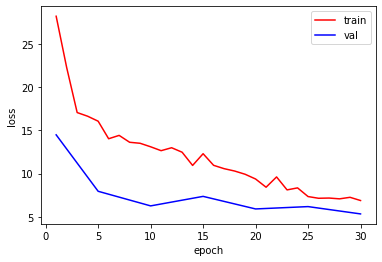

In [15]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

models = ['blehnet',
          'vgg-11', 'vgg-13', 'vgg-16',
          'resnet-0', 'resnet-34', 'resnet-50', 'resnet-101', 'resnet-152']
arch = 'blehnet'
model = AgeRegressorNet(arch).to(device)
model.train()
print('Model {}, number of parameters: {}'.format(arch, model.count_params()))

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = [] 
epoch_val_log = []

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    loss_train = train(model, optimizer, dataloader_train)
    loss_train_log.append(loss_train)
    print('\t\tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_train))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = validate(model, dataloader_valid)
        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))
print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Testing

Starting TESTING.
MAE: 5.18281364440918
R2 : 0.8845449567005238


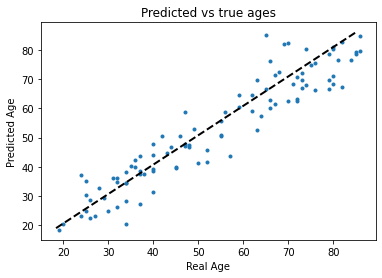


Finished TESTING.


In [ ]:
model_dir = os.path.join(out_dir, 'model')
assert(os.path.exists(model_dir))

arch = 'blehnet'
model = AgeRegressorNet(arch)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()

print('Starting TESTING.')
mae, r2score, y_actual, y_predicted = evaluate(model, dataloader_test)
print('MAE: {0}'.format(mae))
print('R2 : {0}'.format(r2score))

fig, ax = plt.subplots()
ax.title.set_text('Predicted vs true ages')
ax.scatter(y_actual, y_predicted, marker='.')
ax.plot([y_predicted.min(), y_predicted.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()
print('\nFinished TESTING.')